In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import lightgbm as lgb
import xgboost as xgb


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#lettura csv
filepath = r"C:\Users\lucap\OneDrive\Desktop\PhD\Paper SDS\Walden 97-19 integrated v2.csv"
df = pd.read_csv(filepath, sep = ";" )
#df = df[df['m_anno_indagine'] > 2016] #seleziono le righe che riguardano l'osservatorio dal 2019 in poi
df = df[df['m_anno_indagine']>=2017].drop_duplicates(subset='IDU', keep="last")
df = df[
   df.columns[ df.isna().sum() <= 0.3 * len(df) ] ]#seleziono solo le colonne hanno valori Nan inferiori al 30%
# Rimuovere gli spazi bianchi da tutte le colonne
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

le = LabelEncoder()
df['m_sesso'] = le.fit_transform(df['m_sesso'])
df['m_p_pubblico_privato'] = le.fit_transform(df['m_p_pubblico_privato'])
df['m_p_nascita_in_italia_genitori'] = le.fit_transform(df['m_p_nascita_in_italia_genitori'])



# Demografiche
varsToDrop = ['IDU','m_anno_indagine','m_pesos','m_peso',"m_p_cittadinanza", "m_p_data_nascita", "m_modalita_telefono_vs_online",
    'm_p_frequenza_cinema','m_p_frequenza_teatro','m_p_frequenza_concerti',
        'm_p_frequenza_mostre','m_p_frequenza_palestra_sport',
            'm_modernizz_vs_regress_Paese',
                'm_fiducia_proprieIdee_rispetto_avvenimentiMondo','m_p_comune_istat',
                'm_p_data_nascita','m_p_eta_6',\
                    'm_p_in_ita_dal','m_p_origini',
                        'm_p_radio_ore','m_p_lettura_quotidiani','m_p_iscrizione_sindacato',
                            'm_sr_professione','m_sr_statusSocioEconomico_ceto',"m_p_autocol"
                              ,"m_istat_reg"] # rimuovo regioni perchè uso one hot e non voglio aumentare troppo il numero di colonne

df= df.drop(varsToDrop, axis=1)

C:\Users\lucap\AppData\Local\Temp\ipykernel_1600\1065719725.py:3: DtypeWarning: Columns (0,4,8,9,10,11,12,13,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,44,45,46,47,49,50,51,52,53,54,55,61,62,63,64,65,66,68,69,70,71,78,80,82,84,85,86,87,91,93,94,96,97,98,99,101,102,103,105,106,108,109,110,111,113,114,115,117,118,119,120,121,123,124,125,126,128,129,130,132,133,134,136,137,138,139,140,142,143,144,145,146,147,148,150,151,153,154,155,157,158,159,162,164,165,166,167,169,170,171,172,173,174,175,176,177,178,179,180,181,182,184,185,186,187,188,189,190,191,192,194,195,196,197,198,199,200,201,202,203,204,205,207,209,211,212,213,214,215,217,218,219,221,222,223,224,225,226,227,228,229,230,231,232,233,235,236,239,240,242,243,245,246,248,249,250,251,252,253,254,255,256,257,258,261,263,264,265,266,267,272,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,292,293,294,295,296,297,298,299,300,301,302,303,305,306,307,309,310,311,312,313,314,316,317,318,320,321,3

In [4]:
varsToDrop_val = ["m_op_unita_nazionale", "m_op_costituzione.1","m_op_miglioramento_rapp_stato_cittadini",
    "m_op_disorientamento_realta_quotidiana_vs_3anniFa", "m_op_ventennio", "m_op_attitudine_italiani_fascismo", "m_op_criminalita_ultimiAnni_doveVive",
    "m_op_situazEconomic_propria_ultimi10anni", "m_op_situazEconomic_futura", "m_op_legge_aborto_1987", "m_op_tensioneSociale_italianiVSextracom_propriaCitta",
    "m_op_organizzazioneEuropa_futuro","m_op_sentimento_italianoVSeuropeo", "m_op_importanza_essereItaliano", "m_op_fiducia_in_sindacati",
    "m_op_attenzione_personeNelTerritorio_verso_risparmioEnergetico", "m_op_fiducia_negli_altri", "m_op_sistemaScolasticoItaliano", "m_op_scuolaPubblica_ultimiAnni",
    "m_op_reazione_a_discussioni_politiche", "m_op_paure_della_vecchiaia", "m_op_reazione_a_discussioni_politiche", "m_op_origine_maggiorImpulso_ripresa_italia",
    "m_op_fiducia_negli amici che fanno parte della sua rete social network",
"m_op_fiducia_nei familiari con cui convive",
"m_op_fiducia_negli italiani",
"m_op_fiducia_nei suoi parenti",
"m_op_fiducia_negli amici e conoscenti dei suoi familiari",
"m_op_fiducia_nei colleghi di lavoro",
"m_op_fiducia_nei vicini di casa",
"m_op_aiutoReciproco_inCasoDiBisogno_degli italiani",
"m_op_aiutoReciproco_inCasoDiBisogno_degli amici che fanno parte della sua rete social network",
"m_op_aiutoReciproco_inCasoDiBisogno_dei familiari con cui convive",
"m_op_aiutoReciproco_inCasoDiBisogno_dei suoi parenti",
"m_op_aiutoReciproco_inCasoDiBisogno_degli amici e conoscenti dei suoi familiari",
"m_op_aiutoReciproco_inCasoDiBisogno_dei colleghi di lavoro",
"m_op_aiutoReciproco_inCasoDiBisogno_dei vicini di casa",
"m_op_causePrincipali_violenzaDonne_1",
"m_op_causePrincipali_violenzaDonne_2",
"m_op_circostanze_cheGiustificano_violenzaMoglie",
"m_op_priorita_per_affrontare_violenzaDonne_1",
"m_op_priorita_per_affrontare_violenzaDonne_2",
"m_ac_preparazione_nuoveGenerazioni_piuScadente",
"m_op_rimanere_in_propriaZona_vs_spostarsi",
"m_op_preferenza_lavorativa",
"m_op_definizione_bene_comune",
"m_op_ottica_di_beneComune_italia",
"m_op_ottica_di_beneComune_comuneResidenza",
"m_op_pericoliEdisagi_figli_cheSpaventano_genitori_01",
"m_op_pericoliEdisagi_figli_cheSpaventano_genitori_02",
"m_op_pericoliEdisagi_figli_cheSpaventano_genitori_03",
"m_op_pericoliEdisagi_figli_cheSpaventano_genitori_04",
"m_op_cosa_contradistingue_comunita",
"m_op_caratteristiche_dei_politici_apprezzati",
"m_op_definizione_populismo",
"m_op_danni_populismo_in_italia",
"m_op_quanto_populista_PD",
"m_op_quanto_populista_M5S",
"m_op_quanto_populista_Lega",
"m_op_quanto_populista_FI",
"m_op_attualita_concetti_sinistraCentroDestra",
"m_TREND_15_FASCISMO NEW",
"m_op_cambio_legge_aborto",
"m_op_favore_eutanasia_a_determinate_condizioni",
"m_op_attenzione_personeNelTerritorio_verso_ricicloRaccoltaDiff",
"m_op_attenzione_personeNelTerritorio_verso_sistemiEnergieAlternative",
"m_op_attenzione_personeNelTerritorio_verso_acquaistoProdottiEcosostenibili",
"m_op_attenzione_personeNelTerritorio_verso_impegnoTutelaAmbienteNatura",
"m_op_attenzione_personeNelTerritorio_verso_controlloQualitaProvenienzaAlimenti",
"m_op_contributoDelSingolo_salvaguardia_ambiente",
"m_op_impegnoPersone_in_tutelaAmbiente",
"m_op_inclusione_societa",
"m_op_partecipazione_in_UE",
"m_op_comunita_appartenenza_01",
"m_op_disorientamento_veros_realta_quotidiana",
"m_op_rinuncie_per_postoStabile",
"m_op_margineIntervento_vita",
"m_op_profilo_socioCulturale_vs_genitori"
]
df= df.drop(varsToDrop_val, axis=1)

In [5]:
df.head()

,m_sesso,m_p_r_eta,m_p_scolarita,m_p_pubblico_privato,m_p_r_ampiezza6,m_p_zona_5istat,m_p_nascita_in_italia_genitori,m_ac_valore_attuale_patria,m_ac_privilegio_lavoratori_sett_pubblico,m_ac_propensioneRischio_italia_vs_europa,m_ac_importanza_partiti,m_ac_diminuzione_ruolo_partiti,m_ac_affidamento_pubblica_tecnici,m_ac_valori_resistenza_altra_epoca,m_ac_sindacato_ancoraUtile,m_ac_uguaglianza_sociale_frena_individui,m_ac_troppo_focus_uguaglianza_vs_merito,m_ac_meglio_uguaglianza_vs_merito_singolo,m_ac_vantaggi_globalizz_economie_mercati,m_ac_globaliz_inarrestabile,m_ac_dovere_difesa_produzPaese_vs_globaliz,m_ac_aumento_competizione_con_piuPreparati,m_ac_aumento_stress_competizione,m_ac_percez_inadeguatezza_da_velocitaCambiamento,m_ac_nonSicuro_doveVive,m_ac_repressione_unicaArma_vs_crimin,m_ac_crimin_diventera_incontenibile,m_op_come_reddito_consenteDiVivere,m_ac_validita_insegnamChiesa,m_ac_societa_troppoPermissiva_gay,m_ac_legalizz_drogheLeggere,m_ac_chiesa_nonDovrebbe_condizionare_stato.1,m_ac_testamento_biologico,m_ac_immigrati_rubano_lavoro,m_ac_immigrati_risorsa,m_ac_immigrati_portano_criminalita,m_ac_immigrati_devono_adeguarsi,m_ac_immigrati_diritto_voto,m_ac_immigrati_nonRispettano_regoleDelloStareInsieme,m_ac_modernizzazioneItalia_grazie_UE,m_ac_giovani di 30anniFa miglioriDiOggi,m_ac_giovaniOggi_incapaci_fareSacrifici,m_ac_nuoveGenerazioni_miglioreranno_mondo,m_ac_impegnoSocialeGiovani_sempreMenoForte,m_ac_governatori_scegliere_senzaBadareOpposizione,m_ac_mediazione_nonRisolve_problemi,m_ac_ricercaCompromesso_faMarcire_situazioni,m_ac_religioneIslamica_pericoloPerTutti,m_ac_musulmaniInItalia_dirittoReligione_inScuole,m_ac_italia_troppeConcessioni_immigratiMusulmani,m_ac_generazioniFuture_vivrannoPeggio,m_ac_passato_vivereMeglio_ancheSePiuPoveri,m_ac_italia_paeseInDeclino,m_ac_scienza_problemi_piuChe_benefici,m_ac_scoperte_scientificTecnol_rendono_vita_piuFacile,m_ac_troppo_allarmismo_ecologia_inquinamento,m_ac_sviluppoEconomico_incompatibileCon_tutelaAmbiente,m_ac_preoccupazione_situazioneAmbientale_luogoInCuiVivo,m_ac_sacrificioEconomico_per_migliorare_ScuolaUniversitaRicerca,m_ac_ScuolaEFormazione_principaleProblema_delPaese,m_ac_scuola_deveEssere_severa_selettiva_meritocratica,m_ac_valorizzare_scuoleEccellenza,m_ac_difesa_scuolaPubblica_insensata,m_ac_attuale_classeInsegnante_incompetente,m_ac_sperimentazioniGenetiche_piuRischi_cheVantaggi,m_ac_problemi_eticiMorali_sperimentazioneGenetica,m_ac_nord_unicoMotore_economiaItaliana,m_ac_lavoroNord_consente_diEssere_alPasso_con_UE,m_ac_guerre_talvolta_maleNecessario.1,m_ac_italia_ipartecipazioneIn_missioniMilitariEstere,m_ac_lavorare_importante_postoStabile_no,m_ac_badare_propriInteressi_perSopravvivere,m_ac_sentirsiSpesso_solo_isolato,m_ac_modelloImprenditorialePrivato_unico_produceRicchezzaPerTutti,m_ac_modelloImprenditorialePrivato_unico_meritocratico,m_ac_modelloImprenditorialePrivato_unico_garantireEquita,m_ac_italia_riparte_solo_puntandoSu_cittaEterritori_noStatoCentrale,m_ac_dazi_su_produzioni_importanti,m_ac_comprareItaliano_perFronteggiare_crisi,m_ac_generazionePrecedente_piuFelice,m_ac_generazionePrecedente_migliore_qualitaVita,m_ac_generazionePrecedente_maggiore_sicurezzaLavorativa,m_ac_generazionePrecedente_maggiore_mobilitaEconomicoSociale,m_ac_meno_relazioniSociali_amicali_vs_qualcheAnnoFa,m_op_importanza_farParte_comunita,m_op_sviluppo_sensoCivico_Paese,m_op_attività_associazionismo_Italia,m_op_importanza_nellaSocieta_solidarieta,m_op_importanza_nellaSocieta_altruismo,m_op_importanza_nellaSocieta_mutualismo,m_op_peso_volontariato_in_economiaPaese,m_p_int_voto,m_TREND_1_PATRIA E UNITA' NAZIONALE (credono ancora nellla patria),m_TREND_7_SFIDUCIA NEL SISTEMA DEI PARTI,m_TREND_8_VALORI FONDATIVI (mantiene radicati i valori),m_TREND_10_MERITO (propende per la meritocrazia),m_TREND_15_INADEGUATEZZA INDIVIDUALE,m_TREND_19_SICUREZZA - CRIMINALITA' (si sente al sicuro),m_TREND_25_IMMIGRAZIONE (atteggiamento POSITIVO nei confronti degli immigrati),m_TREND_26_NAZIONE 

In [6]:
df.shape

(4504, 116)

In [7]:
df['m_p_int_voto'].value_counts()

m_p_int_voto
sono indeciso                                                     695
Partito Democratico-PD                                            608
MoVimento 5 Stelle                                                580
Partito Democratico                                               364
Lega con Salvini                                                  299
Movimento 5 stelle                                                289
Lega                                                              244
Forza Italia                                                      214
Lega Nord                                                         173
non andrei a votare                                               157
preferisco non rispondere                                         150
Fratelli d'Italia                                                 112
voterei  scheda bianca / annullerei la scheda                      85
Sinistra italiana (SEL + altri)                                    67
Altro p

In [8]:
diz_aliases_int_voto_deep = {"Partito Democratico-PD":'PD',
                "Partito Democratico":'PD',
                "Lega con Salvini":'Lega',
                "Lega Nord":'Lega',
                "Lega":'Lega',
                "Forza Italia":'Centro Dx',
                "Fratelli d'Italia":"Centro Dx",
                'MoVimento 5 Stelle':'M5S',
                'Movimento 5 stelle':'M5S',
                'voterei  scheda bianca / annullerei la scheda':'astensione/bianca/nulla',
                'voterei scheda bianca / scheda nulla':'astensione/bianca/nulla',
                "+Europa":'Minoranze Sx/CSx',
                "piu' Europa con Emma Bonino": "Minoranze Sx/CSx",
                'Sinistra italiana (SEL + altri)':'Minoranze Sx/CSx',
                'Potere al Popolo':'Minoranze Sx/CSx',
                'Rifondazione Comunista':'Minoranze Sx/CSx',
                "Fratelli d'Italia-Alleanza Nazionale&nbsp;":"Centro Dx",
                'La Sinistra':'Minoranze Sx/CSx',
                'Verdi':'Minoranze Sx/CSx',
                'non andrei a votare':'astensione/bianca/nulla',
                'sono indeciso' : 'indecisi',
                'Liberi e Uguali' : 'Minoranze Sx/CSx',
                'Italia dei Valori' : 'Minoranze Sx/CSx',
                'Scelta Civica&nbsp;' : 'Minoranze Sx/CSx',
                'Italia Unica di Corrado Passera' : 'Minoranze Sx/CSx',
                "Noi con l'Italia UDC&nbsp;" : 'Altro partito',
                "altro partito di area di governo (SVP, Centro Democratico....)" : 'Altro partito',
                "Nuovo Centro Destra con UDC e PPI" : 'Centro Dx'
                }

In [9]:
diz_aliases_int_voto = {"Partito Democratico-PD":'Sx/CSx',
                "Partito Democratico":'Sx/CSx',
                "Lega con Salvini":'Dx/CDx',
                "Lega Nord":'Dx/CDx',
                "Lega":'Dx/CDx',
                "Forza Italia":'Dx/CDx',
                "Fratelli d'Italia":"Dx/CDx",
                'MoVimento 5 Stelle':'M5S',
                'Movimento 5 stelle':'M5S',
                'voterei  scheda bianca / annullerei la scheda':'astensione/indecisi',
                'voterei scheda bianca / scheda nulla':'astensione/indecisi',
                "+Europa":'Sx/CSx',
                "piu' Europa con Emma Bonino": "Sx/CSx",
                'Sinistra italiana (SEL + altri)':'Sx/CSx',
                'Potere al Popolo':'Sx/CSx',
                'Rifondazione Comunista':'Sx/CSx',
                "Fratelli d'Italia-Alleanza Nazionale&nbsp;":"Dx/CDx",
                'La Sinistra':'Sx/CSx',
                'Verdi':'Sx/CSx',
                'non andrei a votare':'astensione/indecisi',
                'sono indeciso' : 'astensione/indecisi',
                'Liberi e Uguali' : 'Sx/CSx',
                'Italia dei Valori' : 'Sx/CSx',
                'Scelta Civica&nbsp;' : 'Sx/CSx',
                'Italia Unica di Corrado Passera' : 'Sx/CSx',
                "Noi con l'Italia UDC&nbsp;" : 'Dx/CDx',
                "altro partito di area di governo (SVP, Centro Democratico....)" : 'Altro partito',
                "Nuovo Centro Destra con UDC e PPI" : 'Dx/CDx'
                }

In [10]:
df['m_p_int_voto'] = df['m_p_int_voto'].replace(diz_aliases_int_voto)
df['m_p_int_voto'].value_counts()

m_p_int_voto
Sx/CSx                       1348
Dx/CDx                       1102
astensione/indecisi           969
M5S                           869
preferisco non rispondere     150
Altro partito                  66
Name: count, dtype: int64

In [11]:
df = df[~df['m_p_int_voto'].isin(['Altro partito', 'preferisco non rispondere', 'indecisi','astensione/indecisi' ])]
#df = df[~df['m_p_int_voto'].isin(['Altro partito', 'preferisco non rispondere'])]

In [12]:
class_names = ['Dx/CDx', 'M5S', 'Sx/CSx']

In [13]:
df['m_p_int_voto'].value_counts()

m_p_int_voto
Sx/CSx    1348
Dx/CDx    1102
M5S        869
Name: count, dtype: int64

In [14]:
df.shape

(3319, 116)

In [15]:
diz_aliases_ac = {"del tutto d'accordo":2,
            "del tutto<BR>d'accordo":2,
		     "d'accordo":1,
		     "ne' d'accordo ne' in disaccordo (NON STIMOLARE)":0,
             "ne d'accordo ne' in disaccordo":0,
             "ne' d'accordo ne' in disaccordo":0,
             "preferisco non rispondere":0,
             "preferisco<BR>non<BR> rispondere":0,
            "non saprei":0,
             "in disaccordo":-1,
             'del tutto in disaccordo':-2,
             "del tutto disaccordo":-2,
             "del tutto<BR>in disaccordo":-2,
             
            
}

nomi_var = df.columns.tolist()
for var in nomi_var:
    if '_ac_' in var:
        df[var] = df[var].replace(diz_aliases_ac)

In [16]:
diz_aliases_op = {"molto":2,
            "poco":-1,
		     "abbastanza":1,
		     "non saprei":0,
            "nessuno":-2,
            "per niente":-2}

nomi_var = df.columns.tolist()
for var in nomi_var:
    if 'op' in var:
        df[var] = df[var].replace(diz_aliases_op)

In [17]:
diz_aliases_trend = {"in trend":1,
                 "slight in trend":1,
                 "slight off trend":0,
                 "off trend":0,
                 'non classificati':0}
 
nomi_var = df.columns.tolist()
for var in nomi_var:
    if 'TREND' in var:
        df[var] = df[var].replace(diz_aliases_trend)

In [18]:
diz_aliases_scol = {"elementare/privo di titolo":1,
                 "media inferiore":1,
                 "diploma di maturita` (5 anni)":2,
                 "superiori in corso":2,
                 'diploma di istituto professionale (3 anni)':2,
                 'universita` in corso/nessuna laurea conseguita':4,
                 'laurea triennale di I livello':4,
                 'diploma universitario/laurea breve':4,
                 'laurea specialistica di II livello o laurea 4-5 anni':4,
                 'master/scuola di specializzazione post laurea':4,
                 'dottorato di ricerca':4
                 }
 
df['m_p_scolarita'] = df['m_p_scolarita'].replace(diz_aliases_scol)

In [19]:
diz_aliases_geo = {'meno di 5.000':1,
                 'da 5.001 a 10.000':1,
                 'da 10.001 a 30.000':2,
                 'da 30.001 a 100.000':2,
                 'da 100.001 a 250.000':3,
                 'piu` di 250.001':3
                 }
 
df['m_p_r_ampiezza6'] = df['m_p_r_ampiezza6'].replace(diz_aliases_geo)

In [20]:
diz_aliases_eco = {
                 "mi sento povero e non arrivo mai a fine mese":-1,
                 "avverto difficolta'":-1,
                 "arrivo a fine mese con molte difficolta'":-1,
                 "con tranquillita'":1,
                 'agiatamente':1
                 }
 
df['m_op_come_reddito_consenteDiVivere'] = df['m_op_come_reddito_consenteDiVivere'].replace(diz_aliases_eco)

In [21]:
df = pd.get_dummies(df, columns=['m_p_zona_5istat'], prefix='zona')

In [22]:
df.head()

,m_sesso,m_p_r_eta,m_p_scolarita,m_p_pubblico_privato,m_p_r_ampiezza6,m_p_nascita_in_italia_genitori,m_ac_valore_attuale_patria,m_ac_privilegio_lavoratori_sett_pubblico,m_ac_propensioneRischio_italia_vs_europa,m_ac_importanza_partiti,m_ac_diminuzione_ruolo_partiti,m_ac_affidamento_pubblica_tecnici,m_ac_valori_resistenza_altra_epoca,m_ac_sindacato_ancoraUtile,m_ac_uguaglianza_sociale_frena_individui,m_ac_troppo_focus_uguaglianza_vs_merito,m_ac_meglio_uguaglianza_vs_merito_singolo,m_ac_vantaggi_globalizz_economie_mercati,m_ac_globaliz_inarrestabile,m_ac_dovere_difesa_produzPaese_vs_globaliz,m_ac_aumento_competizione_con_piuPreparati,m_ac_aumento_stress_competizione,m_ac_percez_inadeguatezza_da_velocitaCambiamento,m_ac_nonSicuro_doveVive,m_ac_repressione_unicaArma_vs_crimin,m_ac_crimin_diventera_incontenibile,m_op_come_reddito_consenteDiVivere,m_ac_validita_insegnamChiesa,m_ac_societa_troppoPermissiva_gay,m_ac_legalizz_drogheLeggere,m_ac_chiesa_nonDovrebbe_condizionare_stato.1,m_ac_testamento_biologico,m_ac_immigrati_rubano_lavoro,m_ac_immigrati_risorsa,m_ac_immigrati_portano_criminalita,m_ac_immigrati_devono_adeguarsi,m_ac_immigrati_diritto_voto,m_ac_immigrati_nonRispettano_regoleDelloStareInsieme,m_ac_modernizzazioneItalia_grazie_UE,m_ac_giovani di 30anniFa miglioriDiOggi,m_ac_giovaniOggi_incapaci_fareSacrifici,m_ac_nuoveGenerazioni_miglioreranno_mondo,m_ac_impegnoSocialeGiovani_sempreMenoForte,m_ac_governatori_scegliere_senzaBadareOpposizione,m_ac_mediazione_nonRisolve_problemi,m_ac_ricercaCompromesso_faMarcire_situazioni,m_ac_religioneIslamica_pericoloPerTutti,m_ac_musulmaniInItalia_dirittoReligione_inScuole,m_ac_italia_troppeConcessioni_immigratiMusulmani,m_ac_generazioniFuture_vivrannoPeggio,m_ac_passato_vivereMeglio_ancheSePiuPoveri,m_ac_italia_paeseInDeclino,m_ac_scienza_problemi_piuChe_benefici,m_ac_scoperte_scientificTecnol_rendono_vita_piuFacile,m_ac_troppo_allarmismo_ecologia_inquinamento,m_ac_sviluppoEconomico_incompatibileCon_tutelaAmbiente,m_ac_preoccupazione_situazioneAmbientale_luogoInCuiVivo,m_ac_sacrificioEconomico_per_migliorare_ScuolaUniversitaRicerca,m_ac_ScuolaEFormazione_principaleProblema_delPaese,m_ac_scuola_deveEssere_severa_selettiva_meritocratica,m_ac_valorizzare_scuoleEccellenza,m_ac_difesa_scuolaPubblica_insensata,m_ac_attuale_classeInsegnante_incompetente,m_ac_sperimentazioniGenetiche_piuRischi_cheVantaggi,m_ac_problemi_eticiMorali_sperimentazioneGenetica,m_ac_nord_unicoMotore_economiaItaliana,m_ac_lavoroNord_consente_diEssere_alPasso_con_UE,m_ac_guerre_talvolta_maleNecessario.1,m_ac_italia_ipartecipazioneIn_missioniMilitariEstere,m_ac_lavorare_importante_postoStabile_no,m_ac_badare_propriInteressi_perSopravvivere,m_ac_sentirsiSpesso_solo_isolato,m_ac_modelloImprenditorialePrivato_unico_produceRicchezzaPerTutti,m_ac_modelloImprenditorialePrivato_unico_meritocratico,m_ac_modelloImprenditorialePrivato_unico_garantireEquita,m_ac_italia_riparte_solo_puntandoSu_cittaEterritori_noStatoCentrale,m_ac_dazi_su_produzioni_importanti,m_ac_comprareItaliano_perFronteggiare_crisi,m_ac_generazionePrecedente_piuFelice,m_ac_generazionePrecedente_migliore_qualitaVita,m_ac_generazionePrecedente_maggiore_sicurezzaLavorativa,m_ac_generazionePrecedente_maggiore_mobilitaEconomicoSociale,m_ac_meno_relazioniSociali_amicali_vs_qualcheAnnoFa,m_op_importanza_farParte_comunita,m_op_sviluppo_sensoCivico_Paese,m_op_attività_associazionismo_Italia,m_op_importanza_nellaSocieta_solidarieta,m_op_importanza_nellaSocieta_altruismo,m_op_importanza_nellaSocieta_mutualismo,m_op_peso_volontariato_in_economiaPaese,m_p_int_voto,m_TREND_1_PATRIA E UNITA' NAZIONALE (credono ancora nellla patria),m_TREND_7_SFIDUCIA NEL SISTEMA DEI PARTI,m_TREND_8_VALORI FONDATIVI (mantiene radicati i valori),m_TREND_10_MERITO (propende per la meritocrazia),m_TREND_15_INADEGUATEZZA INDIVIDUALE,m_TREND_19_SICUREZZA - CRIMINALITA' (si sente al sicuro),m_TREND_25_IMMIGRAZIONE (atteggiamento POSITIVO nei confronti degli immigrati),m_TREND_26_NAZIONE EUROPA,m_TREND_2

In [23]:
df.shape

(3319, 120)

Classificatore

In [24]:
# provo a rimuovere le righe con i valori Nan poiché solo 285
df = df.dropna()

In [25]:
df.shape

(3117, 120)

In [68]:
X = df.drop(columns = ['m_p_int_voto'])
y = df.m_p_int_voto

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assicurati di avere colonne numeriche nel tuo DataFrame X
# Seleziona solo le colonne numeriche se necessario
X_numerico = X.select_dtypes(include=['float64', 'int64'])

# Calcola il VIF per ciascuna variabile
vif_data = pd.DataFrame()
vif_data["Variabile"] = X_numerico.columns
vif_data["VIF"] = [variance_inflation_factor(X_numerico.values, i) for i in range(X_numerico.shape[1])]

In [69]:
# Assuming y contains your string labels
label = ['Dx/CDx', 'M5S', 'Sx/CSx']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform y
y_encoded = label_encoder.fit_transform(y)

# Now y_encoded contains integer labels
print("Valori numerici delle etichette:")
print(y_encoded)

# Conoscere la corrispondenza tra le etichette originali e i nuovi valori numerici
print("Corrispondenza tra etichette originali e nuovi valori numerici:")
for label, value in zip(y, y_encoded):
    print(f"{label} --> {value}")


Valori numerici delle etichette:
[2 1 2 ... 2 0 0]
Corrispondenza tra etichette originali e nuovi valori numerici:
Sx/CSx --> 2
M5S --> 1
Sx/CSx --> 2
Sx/CSx --> 2
M5S --> 1
Sx/CSx --> 2
Sx/CSx --> 2
Dx/CDx --> 0
M5S --> 1
Sx/CSx --> 2
Dx/CDx --> 0
Sx/CSx --> 2
M5S --> 1
M5S --> 1
Dx/CDx --> 0
M5S --> 1
Dx/CDx --> 0
M5S --> 1
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
M5S --> 1
Dx/CDx --> 0
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
M5S --> 1
M5S --> 1
Sx/CSx --> 2
Sx/CSx --> 2
M5S --> 1
Dx/CDx --> 0
M5S --> 1
M5S --> 1
M5S --> 1
Sx/CSx --> 2
Dx/CDx --> 0
M5S --> 1
Dx/CDx --> 0
Dx/CDx --> 0
M5S --> 1
Dx/CDx --> 0
M5S --> 1
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
M5S --> 1
Dx/CDx --> 0
Sx/CSx --> 2
Dx/CDx --> 0
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
Dx/CDx --> 0
Sx/CSx --> 2
Dx/CDx --> 0
Sx/CSx --> 2
Dx/CDx --> 0
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
Sx/CSx --> 2
Dx/

['Dx/CDx', 'M5S', 'Sx/CSx']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state = 42, stratify=y)

In [28]:
rf_classifier = RandomForestClassifier() 

parametri_grid_rf = {
    'n_estimators': [100, 150],
    'max_depth': [20, 30],
    'min_samples_split': [10, 20],
    'criterion':['gini', 'entropy'],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True, False]
}


In [49]:
lgb_classifier = lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=4, importance_type='split',random_state=42)

parametri_grid_lgb = {
            #'num_leaves' : [21, 31, 41],
            'learning_rate' : [0.1,0.01],
            'n_estimators' : [70, 80, 100],
            'max_depth' : [10, 15, 20],
            'colsample_bytree' : [0.5,0.8,1],
            'reg_alpha' : [0, 0.1],
            'reg_lambda' : [1,5],
            }

In [58]:
xgb_classifier = xgb.XGBClassifier(objective = "multi:softmax", n_jobs=4, random_state=42)

parametri_grid_xgb = {
    'learning_rate': [0.1, 0.05],#'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [80, 100],
    'max_depth': [ 5, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]#'reg_lambda': [0, 0.1, 0.5]
            }

In [51]:
grid_search_rf = GridSearchCV(rf_classifier , parametri_grid_rf, cv=5,
                               scoring='accuracy',
                               return_train_score=True,n_jobs=4,verbose=2)

In [33]:
# Esegui la Grid Search sul set di addestramento
y_pred = grid_search_rf.fit(X_train, y_train)

# Stampa i parametri migliori trovati
print("Migliori parametri:", grid_search_rf.best_params_)

# Valuta il modello migliore sul set di test
accuracy = grid_search_rf.best_estimator_.score(X_test, y_test)
print("Accuratezza sul set di test:", accuracy)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Migliori parametri: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Accuratezza sul set di test: 0.6698717948717948


In [34]:
grid_search_rf.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_leaf=2,
                       min_samples_split=10)

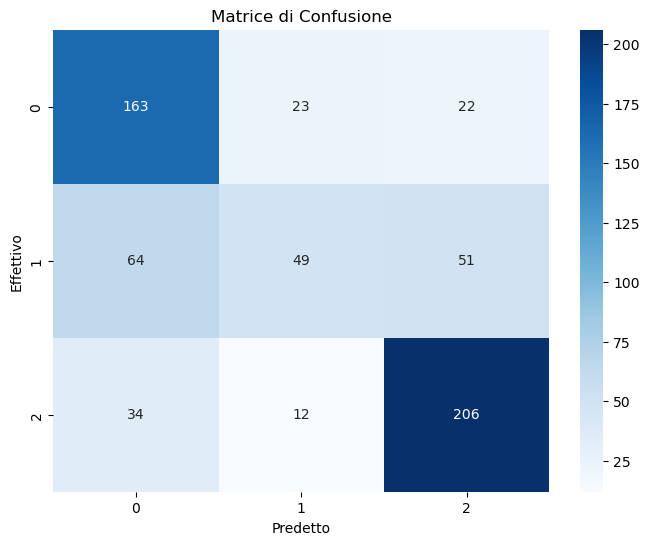

Classification Report:
              precision    recall  f1-score   support

      Dx/CDx       0.62      0.78      0.70       208
         M5S       0.58      0.30      0.40       164
      Sx/CSx       0.74      0.82      0.78       252

    accuracy                           0.67       624
   macro avg       0.65      0.63      0.62       624
weighted avg       0.66      0.67      0.65       624



In [35]:
# Estrai il miglior modello
miglior_modello = grid_search_rf.best_estimator_

# Fai previsioni sul set di test
y_pred = miglior_modello.predict(X_test)

# Calcola la matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Visualizza la matrice di confusione utilizzando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice di Confusione")
plt.xlabel("Predetto")
plt.ylabel("Effettivo")
plt.show()

# Visualizza il classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [52]:
grid_search_lgb = GridSearchCV(lgb_classifier , parametri_grid_lgb, cv=5,
                               scoring='accuracy',
                               return_train_score=True,n_jobs=4,verbose=2)

In [53]:
# Esegui la Grid Search sul set di addestramento
y_pred_lgb = grid_search_lgb.fit(X_train, y_train)

# Stampa i parametri migliori trovati
print("Migliori parametri:", grid_search_lgb.best_params_)

# Valuta il modello migliore sul set di test
accuracy_lgb = grid_search_lgb.best_estimator_.score(X_test, y_test)
print("Accuratezza sul set di test:", accuracy_lgb)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 2493, number of used features: 119
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.338135
[LightGBM] [Info] Start training from score -0.905519
Migliori parametri: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 1

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


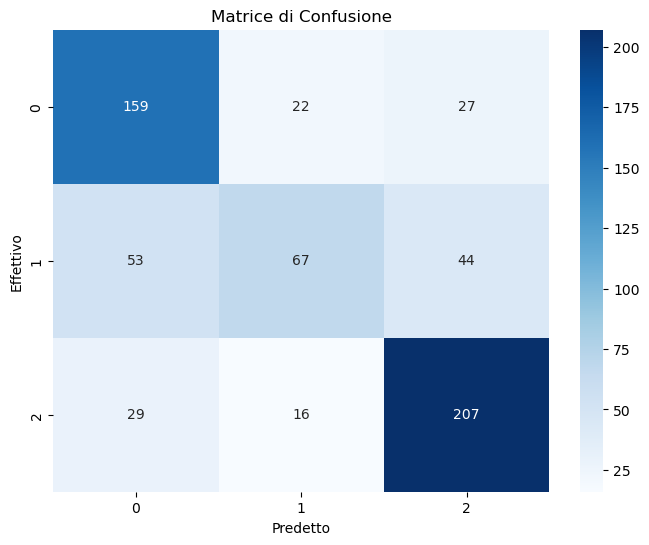

Classification Report:
              precision    recall  f1-score   support

      Dx/CDx       0.66      0.76      0.71       208
         M5S       0.64      0.41      0.50       164
      Sx/CSx       0.74      0.82      0.78       252

    accuracy                           0.69       624
   macro avg       0.68      0.66      0.66       624
weighted avg       0.69      0.69      0.68       624



In [54]:
# Estrai il miglior modello
miglior_modello_lgb = grid_search_lgb.best_estimator_

# Fai previsioni sul set di test
y_pred_lgb = miglior_modello_lgb.predict(X_test)

# Calcola la matrice di confusione
cm_lgb = confusion_matrix(y_test, y_pred_lgb)

# Visualizza la matrice di confusione utilizzando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgb, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice di Confusione")
plt.xlabel("Predetto")
plt.ylabel("Effettivo")
plt.show()

# Visualizza il classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_lgb))

In [55]:
# Visualizza l'importanza delle feature
importances = miglior_modello_lgb.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
1,m_p_r_eta,297
68,m_ac_italia_ipartecipazioneIn_missioniMilitari...,143
54,m_ac_troppo_allarmismo_ecologia_inquinamento,128
30,m_ac_chiesa_nonDovrebbe_condizionare_stato.1,127
29,m_ac_legalizz_drogheLeggere,121
...,...,...
111,m_TREND_52_SOLIDARIETA',10
110,m_TREND_58_CONFRONTO CON LA GENERAZIONE PASSATA,10
103,m_TREND_35_EUROPA E MODERNITA' (crede che l'en...,9
100,m_TREND_29_RADICALIZZAZIONE (crede nel comprom...,7


In [71]:
grid_search_xgb = GridSearchCV(xgb_classifier , parametri_grid_xgb, cv=5,
                               scoring='accuracy',
                               return_train_score=True,n_jobs=4,verbose=2)

In [72]:
# Esegui la Grid Search sul set di addestramento
y_pred_xgb = grid_search_xgb.fit(X_train, y_train)

# Stampa i parametri migliori trovati
print("Migliori parametri:", grid_search_xgb.best_params_)

# Valuta il modello migliore sul set di test
accuracy_xgb = grid_search_xgb.best_estimator_.score(X_test, y_test)
print("Accuratezza sul set di test:", accuracy_xgb)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Migliori parametri: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.9}
Accuratezza sul set di test: 0.6842948717948718


In [39]:
cross_validations = {}

df_cross_validations = pd.DataFrame()

df_X_train_full = X_train
df_X_test_full = X_test

acc_scores = {'n_features':[],'acc_score':[]}
for i in range(len(df_X_train_full.columns),10,-1):
    rfe = RFE(rf_classifier,n_features_to_select=i)
    rfe = rfe.fit(df_X_train_full, y_train.ravel())

    print(set(rfe.feature_names_in_).difference(rfe.get_feature_names_out()))
    X_train_transformed = rfe.transform(df_X_train_full)
    X_test_transformed = rfe.transform(df_X_test_full)
    
    df_X_train_full = pd.DataFrame(X_train_transformed,columns=rfe.get_feature_names_out())
    df_X_test_full = pd.DataFrame(X_test_transformed,columns=rfe.get_feature_names_out())

            
    parametri_grid_lgb = {
            'learning_rate' : [0.1,0.01],
            'n_estimators' : [80, 100],
            'max_depth' : [10,15],
            'colsample_bytree' : [0.5,0.8,1],
            'reg_alpha' : [0, 0.1],
            'reg_lambda' : [1,5]
            }



    grid_search = GridSearchCV(lgb_classifier, parametri_grid_lgb, cv=5,
                           scoring='accuracy',
                           return_train_score=True,n_jobs=4)
    grid_search.fit(df_X_train_full, y_train.ravel())
    cross_validations[i] = grid_search 
    _tmp_cv = pd.DataFrame(grid_search.cv_results_)
    _tmp_cv['n_features'] = i
    _tmp_cv['features'] = ','.join([column for column in rfe.get_feature_names_out() ])
    
    df_cross_validations = pd.concat([df_cross_validations,_tmp_cv])
    
    model = grid_search.best_estimator_
    model.fit(df_X_train_full,y_train.ravel())
    y_pred = model.predict(df_X_test_full)  
    accuracy = accuracy_score(y_test,y_pred)
    print(accuracy)
    acc_scores['n_features'].append(i)
    acc_scores['acc_score'].append(accuracy)
    
 

set()
0.6939102564102564
{'m_p_nascita_in_italia_genitori'}
0.6955128205128205
{"m_TREND_52_SOLIDARIETA'"}
0.6858974358974359
{"m_TREND_31_EPOCALITA' E FUTURO SMARRITO (nostalgico nei confronti del passato)"}
0.6971153846153846
{'zona_Centro'}
0.6891025641025641
{'m_TREND_28_GIOVANI (fiducia alle nuove generazioni)'}
0.6923076923076923
{"m_TREND_37_SCIENZA FECONDA (crede nelle potenzialita' dell'innovazione scientifica)"}
0.6923076923076923
{'m_TREND_46_SPERIMENTAZIONE GENETICA'}
0.6858974358974359
{'m_TREND_15_INADEGUATEZZA INDIVIDUALE'}
0.6923076923076923
{'m_TREND_58_CONFRONTO CON LA GENERAZIONE PASSATA'}
0.6746794871794872
{"m_TREND_39_SCUOLA E FORMAZIONE (formazione e' una priorita' del Paese)"}
0.6939102564102564
{"m_TREND_35_EUROPA E MODERNITA' (crede che l'entrata in Europa abbia modernizzato il nostro paese)"}
0.6907051282051282
{"m_TREND_1_PATRIA E UNITA' NAZIONALE (credono ancora nellla patria)"}
0.6907051282051282
{'zona_Nord-Est'}
0.6939102564102564
{'m_TREND_29_RADICALIZZ

In [43]:
df_cross_validations.sort_values('mean_test_score',ascending=False).head(50)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,n_features,features
14,3.342723,0.053558,0.013192,0.004808,0.5,0.1,15,100,0.1,1,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",0.695391,0.713427,0.681363,0.690763,0.692771,0.694743,0.010472,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,110,"m_sesso,m_p_r_eta,m_p_scolarita,m_p_pubblico_p..."
13,3.372260,0.035285,0.021597,0.007237,0.5,0.1,15,100,0,5,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",0.675351,0.705411,0.695391,0.684739,0.702811,0.692741,0.011273,1,0.998997,0.998495,0.998997,0.998496,0.998496,0.998696,0.000245,118,"m_sesso,m_p_r_eta,m_p_scolarita,m_p_pubblico_p..."
8,2.611196,0.055047,0.011400,0.007160,0.5,0.1,15,80,0,1,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",0.675351,0.705411,0.677355,0.692771,0.710843,0.692346,0.014329,1,1.000000,0.998997,0.999498,0.999499,0.999499,0.999499,0.000317,114,"m_sesso,m_p_r_eta,m_p_scolarita,m_p_pubblico_p..."
10,2.478170,0.061076,0.013546,0.003658,0.5,0.1,15,80,0.1,1,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",0.693387,0.713427,0.685371,0.676707,0.688755,0.691529,0.012233,2,0.999498,0.999498,0.999498,0.998496,0.999499,0.999298,0.000401,110,"m_sesso,m_p_r_eta,m_p_scolarita,m_p_pubblico_p..."
2,2.354551,0.278820,0.013887,0.002288,0.5,0.1,10,80,0.1,1,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",0.675351,0.711423,0.677355,0.682731,0.706827,0.690737,0.015276,1,0.998997,0.998997,0.999498,0.998997,0.998997,0.999097,0.000201,98,"m_p_r_eta,m_p_scolarita,m_p_r_ampiezza6,m_ac_v..."
4,3.172389,0.110441,0.018573,0.006525,0.5,0.1,10,100,0,1,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",0.667335,0.693387,0.685371,0.678715,0.726908,0.690343,0.020177,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,114,"m_sesso,m_p_r_eta,m_p_scolarita,m_p_pubblico_p..."
10,2.219293,0.075421,0.009739,0.005434,0.5,0.1,15,80,0.1,1,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",0.663327,0.705411,0.693387,0.682731,0.706827,0.690336,0.016099,1,1.000000,0.999498,0.999498,0.998997,0.998496,0.999298,0.000511,107,"m_sesso,m_p_r_eta,m_p_scolarita,m_p_pubblico_p..."
12,4.542481,0.289868,0.015138,0.007343,0.5,0.1,15,100,0,1,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",0.673347,0.711423,0.679359,0.680723,0.706827,0.690336,0.015609,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,104,"m_sesso,m_p_r_eta,m_p_scolarita,m_p_r_ampiezza..."
6,2.775247,0.013801,0.010941,0.003739,0.5,0.1,10,100,0.1,1,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",0.671343,0.701403,0.679359,0.690763,0.706827,0.689939,0.013229,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,98,"m_p_r_eta,m_p_scolarita,m_p_r_ampiezza6,m_ac_v..."
5,2.945971,0.043366,0.016707,0.006078,0.5,0.1,10,100,0,5,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",0.657315,0.701403,0.695391,0.686747,0.706827,0.689537,0.017436,1,0.998495,0.997492,0.996991,0.997995,0.997494,0.997694,0.000511,99,"m_p_r_eta,m_p_scolarita,m_p_r_ampiezza6,m_ac_v..."


In [47]:
tab_res = df_cross_validations.sort_values('mean_test_score',ascending=False).head(45)
tab_res = tab_res.tail(1)
tab_res


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,n_features,features
11,1.502616,0.174812,0.009185,0.006113,0.5,0.1,15,80,0.1,5,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",0.667335,0.699399,0.679359,0.688755,0.694779,0.685925,0.01146,1,0.948847,0.953862,0.951856,0.954887,0.950877,0.952066,0.002145,35,"m_p_r_eta,m_ac_propensioneRischio_italia_vs_eu..."


In [48]:
best_features_set = tab_res['features']
best_features_set = tab_res['features'].values[0]
best_features_set = best_features_set.split(',')
best_features_set

['m_p_r_eta',
 'm_ac_propensioneRischio_italia_vs_europa',
 'm_ac_diminuzione_ruolo_partiti',
 'm_ac_affidamento_pubblica_tecnici',
 'm_ac_valori_resistenza_altra_epoca',
 'm_ac_sindacato_ancoraUtile',
 'm_ac_troppo_focus_uguaglianza_vs_merito',
 'm_ac_meglio_uguaglianza_vs_merito_singolo',
 'm_ac_crimin_diventera_incontenibile',
 'm_ac_validita_insegnamChiesa',
 'm_ac_societa_troppoPermissiva_gay',
 'm_ac_legalizz_drogheLeggere',
 'm_ac_chiesa_nonDovrebbe_condizionare_stato.1',
 'm_ac_testamento_biologico',
 'm_ac_immigrati_rubano_lavoro',
 'm_ac_immigrati_risorsa',
 'm_ac_immigrati_portano_criminalita',
 'm_ac_immigrati_diritto_voto',
 'm_ac_immigrati_nonRispettano_regoleDelloStareInsieme',
 'm_ac_modernizzazioneItalia_grazie_UE',
 'm_ac_religioneIslamica_pericoloPerTutti',
 'm_ac_italia_troppeConcessioni_immigratiMusulmani',
 'm_ac_troppo_allarmismo_ecologia_inquinamento',
 'm_ac_difesa_scuolaPubblica_insensata',
 'm_ac_problemi_eticiMorali_sperimentazioneGenetica',
 'm_ac_nord_unic

In [55]:
tab_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,n_features,features
11,1.502616,0.174812,0.009185,0.006113,0.5,0.1,15,80,0.1,5,"{'colsample_bytree': 0.5, 'learning_rate': 0.1...",0.667335,0.699399,0.679359,0.688755,0.694779,0.685925,0.01146,1,0.948847,0.953862,0.951856,0.954887,0.950877,0.952066,0.002145,35,"m_p_r_eta,m_ac_propensioneRischio_italia_vs_eu..."


In [54]:
tab_res['params'].values[0]

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 15,
 'n_estimators': 80,
 'reg_alpha': 0.1,
 'reg_lambda': 5}